In [1]:
import numpy as np
from scipy.stats import poisson
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingRegressor
# from skgarden import RandomForestQuantileRegressor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm.auto import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from datetime import datetime

import argparse
import pickle
import seaborn as sns
import os
import statsmodels.api as sm

from descartes import PolygonPatch
import alphashape

from scipy.stats import multivariate_normal


import sys, traceback

class Suppressor(object):

    def __enter__(self):
        self.stdout = sys.stdout
        sys.stdout = self

    def __exit__(self, type, value, traceback):
        sys.stdout = self.stdout
        if type is not None:
            pass

    def write(self, x): pass

## Figure 4 (left)

In [9]:
directory = 'sims/figure4left/'
files = sorted([x for x in os.listdir(directory) if 'pkl' in x or ('cstar' in x)])
print(files)

class_list = list(set([x.split('_')[11] for x in files if 'cstar' not in x]))
print(class_list)

flnm_cstar = [x for x in files if 'cstar' in x][0]
print(flnm_cstar)

['2d_confint_sen_data_b_1000_bprime_1000_98_10_n10_taustar_cstar_2020-02-05.pkl', '2d_confint_sen_data_b_50000_bprime_25000_98_10_n10_MLP7_pytorch_500_0_taustar_stacked_2020-02-05.pkl', '2d_confint_sen_data_b_50000_bprime_500_98_10_n10_MLP7_RF100_500_0_taustar_stacked_2020-02-05.pkl']
['MLP7']
2d_confint_sen_data_b_1000_bprime_1000_98_10_n10_taustar_cstar_2020-02-05.pkl


MLP7 2d_confint_sen_data_b_50000_bprime_25000_98_10_n10_MLP7_pytorch_500_0_taustar_stacked_2020-02-05.pkl
MLP7 2d_confint_sen_data_b_50000_bprime_500_98_10_n10_MLP7_RF100_500_0_taustar_stacked_2020-02-05.pkl
MLP7 2d_confint_sen_data_b_1000_bprime_1000_98_10_n10_taustar_cstar_2020-02-05.pkl


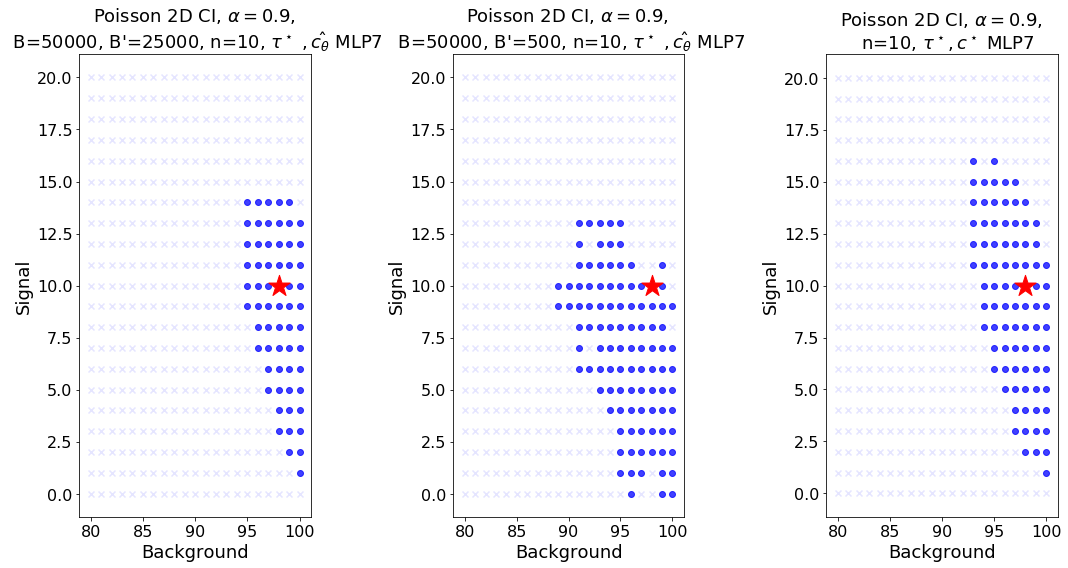

In [10]:
t0_val = [98, 10]
sample_size_obs = 10


for classifier in class_list:
    flnm_temp_list = [x for x in files if x.split('_')[11] == classifier] + [flnm_cstar]

    fig = plt.figure(figsize=(20, 8))
    for jj, flnm in enumerate(flnm_temp_list):
        print(classifier, flnm)

        data_dict = pickle.load(open(directory + flnm, 'rb'))
        b = int(flnm.split('_')[5])  if classifier != 'stacked' else 0
        try:
            b_prime = int(flnm.split('_')[7]) if classifier != 'stacked' else int(flnm.split('_')[6])
        except:
            b_prime = 0
        t_star = 'taustar' in flnm
        c_star = 'cstar' in flnm
        plot_df = pd.DataFrame.from_dict({
            'background': data_dict['background'],
            'signal': data_dict['signal'],
            'tau_statistics': data_dict['tau_statistics'],
            'simul_nh_cutoff': data_dict['simul_nh_cutoff'],
            'simul_nh_decision': data_dict['simul_nh_decision']
        })

        col_vec = ['blue']
        alpha_vec = [0.75, 0.1]
        theta_0_plot = plot_df['background'].values
        theta_1_plot = plot_df['signal'].values

        ax = fig.add_subplot(1, 4, jj + 1)
        for ii, col in enumerate(['simul_nh_decision']):
            value_temp = plot_df[col].values
            marker = np.array(["x" if el else "o" for el in value_temp])
            unique_markers = set(marker)

            for j, um in enumerate(unique_markers):
                mask = marker == um
                plt.scatter(x=theta_0_plot[mask], y=theta_1_plot[mask],
                            marker=um, color=col_vec[ii], alpha=alpha_vec[j])

            plt.scatter(x=t0_val[0], y=t0_val[1], color='r', marker='*', s=500)
            plt.xlabel('Background', fontsize=18)
            plt.ylabel('Signal', fontsize=18)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            b_prime_line = "B=%s, B'=%s," % (b, b_prime) if not c_star else ''
            plt.title("Poisson 2D CI, %s, %s %s n=%s%s%s %s" % (
                r'$\alpha=0.9$', '\n', 
                b_prime_line,
                sample_size_obs,
                r', $\hat{\tau_\theta}$' if not t_star else r', $\tau^\star$',
                r' $,\hat{c_\theta}$' if not c_star else r'$,c^\star$', classifier), fontsize=18)

    plt.tight_layout()
    image_name = 'fig4left_2d_confint_sen_b_%s_bprime_%s_%s_%s_n%s_%s.pdf' % (
        b, b_prime, t0_val[0], t0_val[1], sample_size_obs,
        datetime.strftime(datetime.today(), '%Y-%m-%d'))
    plt.savefig('images/sen_poisson/' + image_name)
    plt.show()

MLP7 2d_confint_sen_data_b_50000_bprime_500_98_10_n10_MLP7_RF100_500_0_taustar_stacked_2020-02-05.pkl
MLP7 2d_confint_sen_data_b_50000_bprime_25000_98_10_n10_MLP7_pytorch_500_0_taustar_stacked_2020-02-05.pkl
MLP7 2d_confint_sen_data_b_1000_bprime_1000_98_10_n10_taustar_cstar_2020-02-05.pkl


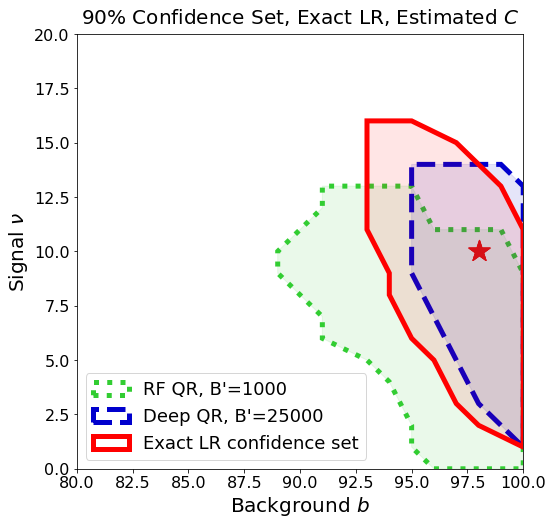

In [20]:
t0_val = [98, 10]
sample_size_obs = 10
alpha_val_hull = 0.5
label_vec = [r"RF QR, B'=1000",
             r"Deep QR, B'=25000",
        r'Exact LR confidence set']
color_vec = [ 'limegreen', 'mediumblue', 'red']
lt_vec = [ 'dotted', 'dashed', 'solid']

for classifier in class_list:
    flnm_temp_list = sorted([x for x in files if x.split('_')[11] == classifier], 
                            key=lambda x: int(x.split('_')[5]))[::-1] + [flnm_cstar]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    for jj, flnm in enumerate(flnm_temp_list):
        print(classifier, flnm)
        data_dict = pickle.load(open(directory + flnm, 'rb'))
        b = int(flnm.split('_')[5]) if classifier != 'stacked' else 0
        try:
            b_prime = int(flnm.split('_')[7]) if classifier != 'stacked' else int(flnm.split('_')[6])
        except:
            b_prime = 0
        t_star = 'taustar' in flnm
        c_star = 'cstar' in flnm

        plot_df = pd.DataFrame.from_dict({
            'background': data_dict['background'],
            'signal': data_dict['signal'],
            'tau_statistics': data_dict['tau_statistics'],
            'simul_nh_cutoff': data_dict['simul_nh_cutoff'],
            'simul_nh_decision': data_dict['simul_nh_decision']
        })

        plot_df_in = plot_df[plot_df['simul_nh_decision'] == 0]
        points = np.hstack((plot_df_in['background'].values.reshape(-1,1),
                            plot_df_in['signal'].values.reshape(-1,1)))
        alpha_shape = alphashape.alphashape(points, alpha=alpha_val_hull)
        ax.add_patch(PolygonPatch(alpha_shape, alpha=1, fill=None,
                                  linewidth=5, linestyle=lt_vec[jj],
                                  label=label_vec[jj],
                                  color=color_vec[jj]))
        ax.add_patch(PolygonPatch(alpha_shape, alpha=0.1,
                                  color=color_vec[jj]))
        ax.scatter(x=t0_val[0], y=t0_val[1], color='r', marker='*', s=500)
        plt.xlabel(r'Background $b$', fontsize=20)
        plt.ylabel(r'Signal $\nu$', fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
    
    plt.title(r"$90\%$ Confidence Set, Exact LR, Estimated $C$", fontsize=20, y=1.01)
    plt.xlim([80, 100])
    plt.ylim([0, 20])
    leg = plt.legend(loc='lower left', fontsize=18)
    image_name = '2d_confint_alphahull_sen_confidence_region_true_lrt_%s_%s_%s.pdf' % (
            t0_val[0], t0_val[1],
            datetime.strftime(datetime.today(), '%Y-%m-%d'))
    plt.savefig('images/sen_poisson/' + image_name,
                bbox_inches='tight')
    plt.show()


## Figure 4 (Center)

In [5]:
directory = 'sims/figure4center/'
files = sorted([x for x in os.listdir(directory) if 'pkl' in x or ('cstar' in x)])
print(files)

class_list = list(set([x.split('_')[11] for x in files if 'cstar' not in x]))
print(class_list)

flnm_cstar = [x for x in files if 'cstar' in x][0]
print(flnm_cstar)

['2d_confint_sen_data_b_100000_bprime_25000_98_10_n10_MLP7_pytorch_500_0_stacked_2020-02-05.pkl', '2d_confint_sen_data_b_1000_bprime_1000_98_10_n10_taustar_cstar_2020-02-05.pkl', '2d_confint_sen_data_b_200000_bprime_25000_98_10_n10_MLP7_pytorch_500_0_stacked_2020-02-05.pkl', '2d_confint_sen_data_b_25000_bprime_25000_98_10_n10_MLP7_pytorch_500_0_stacked_2020-02-05.pkl']
['MLP7']
2d_confint_sen_data_b_1000_bprime_1000_98_10_n10_taustar_cstar_2020-02-05.pkl


MLP7 2d_confint_sen_data_b_100000_bprime_25000_98_10_n10_MLP7_pytorch_500_0_stacked_2020-02-05.pkl
MLP7 2d_confint_sen_data_b_200000_bprime_25000_98_10_n10_MLP7_pytorch_500_0_stacked_2020-02-05.pkl
MLP7 2d_confint_sen_data_b_25000_bprime_25000_98_10_n10_MLP7_pytorch_500_0_stacked_2020-02-05.pkl
MLP7 2d_confint_sen_data_b_1000_bprime_1000_98_10_n10_taustar_cstar_2020-02-05.pkl


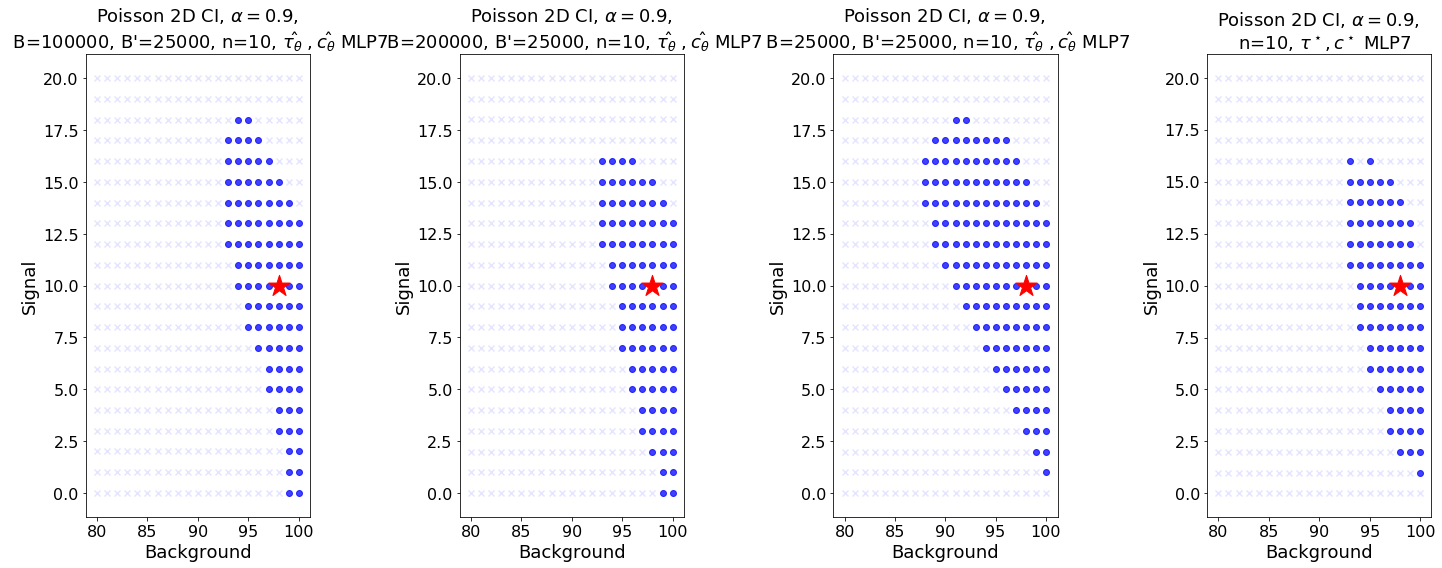

In [6]:
t0_val = [98, 10]
sample_size_obs = 10


for classifier in class_list:
    flnm_temp_list = [x for x in files if x.split('_')[11] == classifier] + [flnm_cstar]
    
    fig = plt.figure(figsize=(20, 8))
    for jj, flnm in enumerate(flnm_temp_list):
        print(classifier, flnm)
        data_dict = pickle.load(open(directory + flnm, 'rb'))
        b = int(flnm.split('_')[5])  if classifier != 'stacked' else 0
        try:
            b_prime = int(flnm.split('_')[7]) if classifier != 'stacked' else int(flnm.split('_')[6])
        except:
            b_prime = 0
        t_star = 'taustar' in flnm
        c_star = 'cstar' in flnm
        
        plot_df = pd.DataFrame.from_dict({
            'background': data_dict['background'],
            'signal': data_dict['signal'],
            'tau_statistics': data_dict['tau_statistics'],
            'simul_nh_cutoff': data_dict['simul_nh_cutoff'],
            'simul_nh_decision': data_dict['simul_nh_decision']
        })

        col_vec = ['blue']
        alpha_vec = [0.75, 0.1]
        theta_0_plot = plot_df['background'].values
        theta_1_plot = plot_df['signal'].values

        ax = fig.add_subplot(1, 4, jj + 1)
        for ii, col in enumerate(['simul_nh_decision']):
            value_temp = plot_df[col].values
            marker = np.array(["x" if el else "o" for el in value_temp])
            unique_markers = set(marker)

            for j, um in enumerate(unique_markers):
                mask = marker == um
                plt.scatter(x=theta_0_plot[mask], y=theta_1_plot[mask],
                            marker=um, color=col_vec[ii], alpha=alpha_vec[j])

            plt.scatter(x=t0_val[0], y=t0_val[1], color='r', marker='*', s=500)
            plt.xlabel('Background', fontsize=18)
            plt.ylabel('Signal', fontsize=18)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            b_prime_line = "B=%s, B'=%s," % (b, b_prime) if not c_star else ''
            plt.title("Poisson 2D CI, %s, %s %s n=%s%s%s %s" % (
                r'$\alpha=0.9$', '\n', 
                b_prime_line,
                sample_size_obs,
                r', $\hat{\tau_\theta}$' if not t_star else r', $\tau^\star$',
                r' $,\hat{c_\theta}$' if not c_star else r'$,c^\star$', classifier), fontsize=18)

    plt.tight_layout()
    image_name = 'fig4center_2d_confint_sen_b_%s_bprime_%s_%s_%s_n%s_%s.pdf' % (
        b, b_prime, t0_val[0], t0_val[1], sample_size_obs,
        datetime.strftime(datetime.today(), '%Y-%m-%d'))
    plt.savefig('images/sen_poisson/' + image_name)
    plt.show()

MLP7 2d_confint_sen_data_b_25000_bprime_25000_98_10_n10_MLP7_pytorch_500_0_stacked_2020-02-05.pkl
MLP7 2d_confint_sen_data_b_100000_bprime_25000_98_10_n10_MLP7_pytorch_500_0_stacked_2020-02-05.pkl
MLP7 2d_confint_sen_data_b_200000_bprime_25000_98_10_n10_MLP7_pytorch_500_0_stacked_2020-02-05.pkl
MLP7 2d_confint_sen_data_b_1000_bprime_1000_98_10_n10_taustar_cstar_2020-02-05.pkl


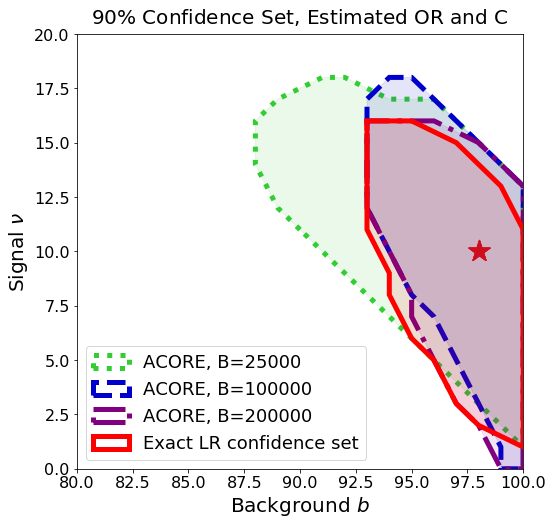

In [8]:
t0_val = [98, 10]
sample_size_obs = 10
alpha_val_hull = 0.5

label_vec = [r"ACORE, B=25000",
            r"ACORE, B=100000",
            r"ACORE, B=200000",
            r'Exact LR confidence set']
color_vec = ['limegreen', 'mediumblue', 'purple', 'red']
lt_vec = ['dotted', 'dashed', 'dashdot', 'solid']

for classifier in class_list:
    flnm_temp_list = sorted([x for x in files if x.split('_')[11] == classifier], 
                            key=lambda x: int(x.split('_')[5])) + [flnm_cstar]
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    flnm_temp_list = sorted([x for x in files if x.split('_')[11] == classifier], 
                            key=lambda x: int(x.split('_')[5])) + [flnm_cstar]
        
        
    for jj, flnm in enumerate(flnm_temp_list):
        print(classifier, flnm)

        data_dict = pickle.load(open(directory + flnm, 'rb'))
        b = int(flnm.split('_')[5]) if classifier != 'stacked' else 0
        try:
            b_prime = int(flnm.split('_')[7]) if classifier != 'stacked' else int(flnm.split('_')[6])
        except:
            b_prime = 0
        t_star = 'taustar' in flnm
        c_star = 'cstar' in flnm
   
        plot_df = pd.DataFrame.from_dict({
            'background': data_dict['background'],
            'signal': data_dict['signal'],
            'tau_statistics': data_dict['tau_statistics'],
            'simul_nh_cutoff': data_dict['simul_nh_cutoff'],
            'simul_nh_decision': data_dict['simul_nh_decision']
        })

        plot_df_in = plot_df[plot_df['simul_nh_decision'] == 0]
        points = np.hstack((plot_df_in['background'].values.reshape(-1,1),
                            plot_df_in['signal'].values.reshape(-1,1)))
        alpha_shape = alphashape.alphashape(points, alpha=alpha_val_hull)
        ax.add_patch(PolygonPatch(alpha_shape, alpha=1, fill=None,
                                  linewidth=5, linestyle=lt_vec[jj],
                                  label=label_vec[jj],
                                  color=color_vec[jj]))
        ax.add_patch(PolygonPatch(alpha_shape, alpha=0.1,
                                  color=color_vec[jj]))
        ax.scatter(x=t0_val[0], y=t0_val[1], color='r', marker='*', s=500)
        plt.xlabel(r'Background $b$', fontsize=20)
        plt.ylabel(r'Signal $\nu$', fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

    plt.title(r"$90\%$ Confidence Set, Estimated OR and C", fontsize=20, y=1.01)

    plt.xlim([80, 100])
    plt.ylim([0, 20])
    leg = plt.legend(loc='lower left', fontsize=18)
    image_name = '2d_confint_alphahull_sen_confidence_region_estimated_dnn_%s_%s_%s.pdf' % (
            t0_val[0], t0_val[1],
            datetime.strftime(datetime.today(), '%Y-%m-%d'))
    plt.savefig('images/sen_poisson/' + image_name,
                bbox_inches='tight')
    plt.show()


## Figure 4 (right)

In [45]:
directory = 'sims/figure4right/'
files = [x for x in os.listdir(directory) if 'csv' in x and 'heatmap' in x]
files

['2d_sen_poisson_heatmap_25000B_25000Bprime_poisson_100rep_alpha0-1_sampleobs10_2020-01-26.csv']

In [46]:
def matrix_mesh(a_tuple):
    return np.hstack((a_tuple[0].reshape(-1, 1), a_tuple[1].reshape(-1, 1)))

QDA 2d_sen_poisson_heatmap_25000B_25000Bprime_poisson_100rep_alpha0-1_sampleobs10_2020-01-26.csv


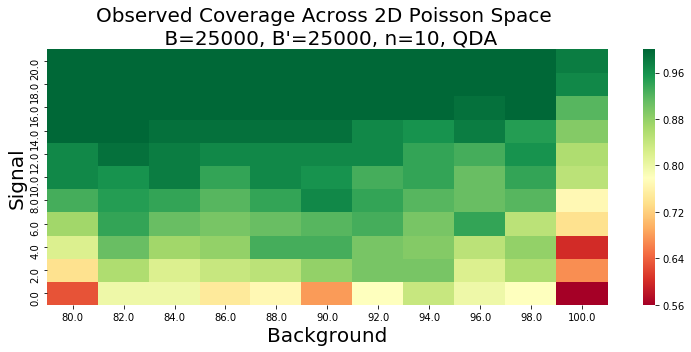

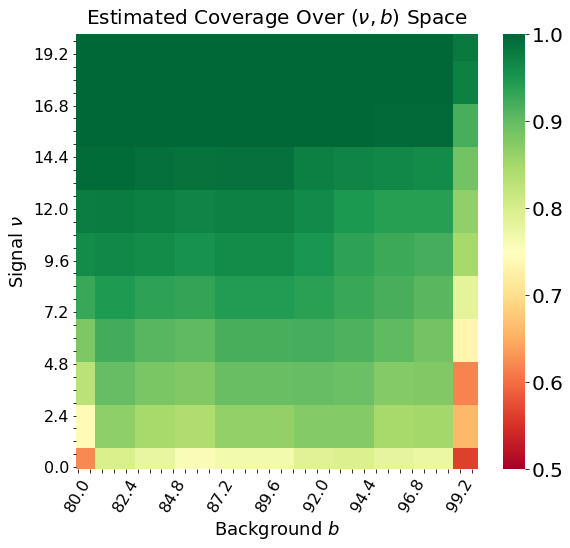

Average Coverage 0.9185123966942149


In [53]:
sample_size_obs = 10
low_int_reference_background = 80
high_int_reference_background = 100
low_int_reference_signal = 0
high_int_reference_signal = 20

for flnm in files:
    out_df = pd.read_csv(directory + flnm)
    b_val = int(flnm.split('_')[4].replace('B', ''))
    
    classifier = out_df['classifier'].unique()[0]
    print(classifier, flnm)
    plot_df = out_df[out_df['on_true_theta'] == 1][['t0_true_ax0', 't0_true_ax1', 'in_confint']]
    plot_df = plot_df.groupby(['t0_true_ax0', 't0_true_ax1']).mean().reset_index()

    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_df_heatmap = plot_df.pivot('t0_true_ax1', 't0_true_ax0', 'in_confint')
    ax = sns.heatmap(plot_df_heatmap, cmap='RdYlGn',
                     vmax=plot_df['in_confint'].max(), vmin=plot_df['in_confint'].min())
    ax.invert_yaxis()
    plt.title("Observed Coverage Across 2D Poisson Space %s B=%s, B'=%s, n=%s, %s" % (
        '\n', b_val, b_val, sample_size_obs, classifier
    ), fontsize=20)
    plt.xlabel('Background', fontsize=20)
    plt.ylabel('Signal', fontsize=20)
    plt.tight_layout()
    plt.show()
    
    
    # Generating Heatmap -- Estimated Coverage
    X_cov = out_df[out_df['on_true_theta'] == 1][['t0_true_ax0', 't0_true_ax1']].values
    y_cov = out_df[out_df['on_true_theta'] == 1]['in_confint'].values
    
    model = XGBClassifier(depth=3, n_estimators=100)
    model.fit(X_cov, y_cov)
    pred_grid = matrix_mesh(np.meshgrid(np.linspace(start=low_int_reference_background,
                                                    stop=high_int_reference_background, num=101),
                                        np.linspace(start=low_int_reference_signal,
                                                    stop=high_int_reference_signal, num=101)))
    pred_cov = model.predict_proba(pred_grid)
    
    
    # Logistic Regression Attempt
    
    plot_df_cov = pd.DataFrame.from_dict({
        't0_true_ax0': np.round(pred_grid[:, 0], 2),
        't0_true_ax1': np.round(pred_grid[:, 1], 2),
        'in_confint': pred_cov[:, 1]
    })
    plot_df_heatmap = plot_df_cov.pivot('t0_true_ax1', 't0_true_ax0', 'in_confint')
    

    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.heatmap(plot_df_heatmap, cmap='RdYlGn',
                     vmax=0.5, vmin=1)
    ax.invert_yaxis()
    plt.title(r'Estimated Coverage Over $(\nu, b)$ Space', fontsize=20, y=1.01)
    plt.xlabel(r'Background $b$', fontsize=18)
    plt.ylabel(r'Signal $\nu$', fontsize=18)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16, rotation=60)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)

    for jj, label in enumerate(ax.xaxis.get_ticklabels()):
        if jj % 4 > 0:
            label.set_visible(False)
        
    for jj, label in enumerate(ax.yaxis.get_ticklabels()):
        if jj % 4 > 0:
            label.set_visible(False)

    image_name = 'heatmap_estimated_coverage_2d_sen_b_%s_bprime_%s_n%s_%s_%s.pdf' % (
        b_val, b_val, sample_size_obs, classifier,
        datetime.strftime(datetime.today(), '%Y-%m-%d'))
    plt.savefig('images/sen_poisson/' + image_name,
               bbox_inches='tight')
    plt.show()
    
    print('Average Coverage', np.average(y_cov))

## Figure 7 (Supp. Mat. Practical Strategy)

### Figure 7 left

In [6]:
directory = 'sims/figure7/'
files = [x for x in os.listdir(directory) if '.csv' in x and 'b_analysis' in x and '5000' in x]
files

['b_analysis_poisson_alpha0-1_sizecheck5000_2020-02-10.csv']

              classifier  entropy_loss
11                  MLP6      0.585094
15                   QDA      0.585124
7                   MLP2      0.588346
17   XGBoost--(d3,-n500)      0.588672
12                  MLP7      0.590597
13                  MLP8      0.591158
9                   MLP4      0.591740
14                    NN      0.591822
16  XGBoost--(d10,-n100)      0.591916
8                   MLP3      0.594305


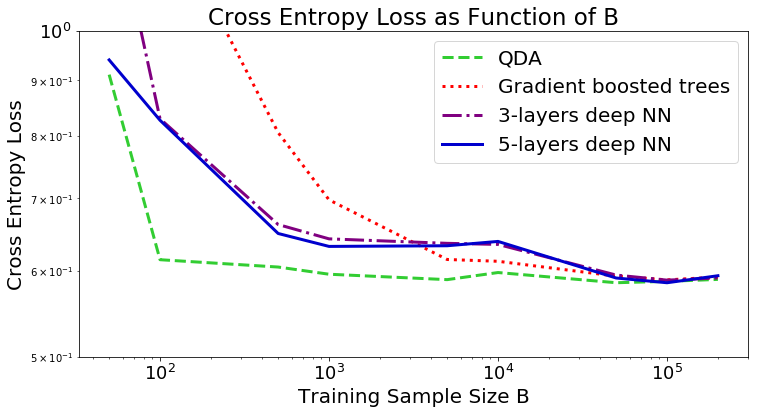

              classifier       b  entropy_loss
90                  MLP6  100000      0.585094
125                  QDA   50000      0.585124
126                  QDA  100000      0.586810
54                  MLP2  100000      0.588346
144  XGBoost--(d3,-n500)  100000      0.588672
123                  QDA    5000      0.588969
127                  QDA  200000      0.589277
99                  MLP7  100000      0.590597
89                  MLP6   50000      0.591020
55                  MLP2  200000      0.591038


In [7]:
label_dict = {'QDA': 'QDA', 
              'MLP6': '5-layers deep NN', 
              'MLP2': '3-layers deep NN',
              'XGBoost--(d3,-n500)': 'Gradient boosted trees'}
color_dict = {'QDA': 'limegreen', 
              'MLP6': 'mediumblue', 
              'MLP2':'purple',
              'XGBoost--(d3,-n500)': 'red'}
lt_dict = {'QDA': 'dashed', 
          'MLP6': 'solid', 
          'MLP2':'dashdot',
          'XGBoost--(d3,-n500)': 'dotted'}

for flnm in files:
    out_df = pd.read_csv(directory + flnm).set_index('Unnamed: 0')
    
    top_n_classifiers = 4
    class_vec = out_df.groupby(['classifier']).agg({'entropy_loss': np.min}).reset_index().sort_values(
        by='entropy_loss', ascending=True)['classifier'].values[:top_n_classifiers]
    
    print(out_df.groupby(['classifier']).agg({'entropy_loss': np.min}).reset_index().sort_values(
        by='entropy_loss', ascending=True).head(10))
    
    plt.figure(figsize=(12,6))
    plot_df = out_df[(out_df['classifier'].isin(class_vec)) & (out_df['b'] >= 50)]
    for jj, classifier in enumerate(plot_df['classifier'].unique()):
        temp_df = plot_df[plot_df['classifier'] == classifier].sort_values('b')
        ax = sns.lineplot(x=np.array(temp_df['b'].values).astype(float),
                y=np.array(temp_df['entropy_loss'].values).astype(float),
                label=label_dict[classifier], linewidth=3,
                color=color_dict[classifier])
        ax.lines[jj].set_linestyle(lt_dict[classifier])

    plt.xlabel('Training Sample Size B', fontsize=20)
    plt.ylabel('Cross Entropy Loss', fontsize=20)
    plt.xscale('log')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(loc='upper right', fontsize=20)
    plt.ylim([0.5, 1])
    plt.yscale('log')
    plt.title('Cross Entropy Loss as Function of B', fontsize=23)
    outfile_name = 'cross_entropy_loss_across_b_%s.pdf' % datetime.strftime(datetime.today(), '%Y-%m-%d')
    plt.savefig('images/sen_poisson/' + outfile_name)
    plt.show()
    
    print(out_df.groupby(['classifier', 'b']).agg({'entropy_loss': np.min}).reset_index().sort_values(
        by='entropy_loss', ascending=True).head(10))

### Figure 7 right

In [3]:
directory = 'sims/figure7/'
files = [x for x in os.listdir(directory) if '.csv' in x and 'b_prime' in x and 'logregint' in x]
files

['b_prime_analysis_QDA_poisson_alpha0-1_ngrid101_sizecheck1000_bprimemax250000.0_logregint_2020-02-14.csv',
 'b_prime_analysis_MLP6_poisson_alpha0-1_ngrid101_sizecheck1000_bprimemax250000.0_logregint_2020-02-14.csv']

QDA
MLP6


/Users/NicDalmasso/python3_envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/NicDalmasso/python3_envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


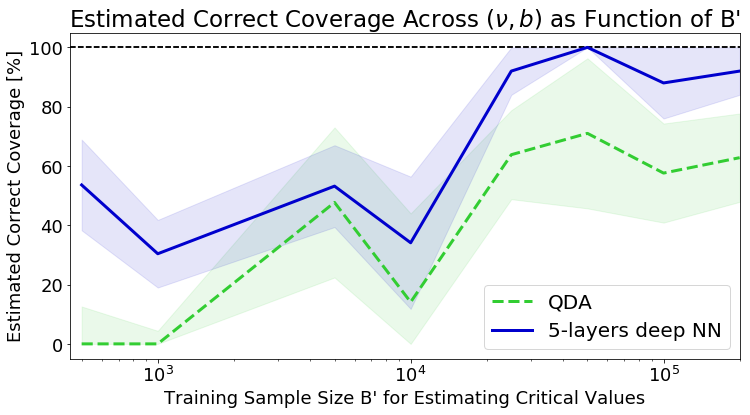

In [4]:
label_dict = {'QDA': 'QDA', 
              'MLP6': '5-layers deep NN', 
              'MLP2': '3-layers deep NN',
              'XGBoost--(d3,-n500)': 'Gradient boosted trees'}
color_dict = {'QDA': 'limegreen', 
              'MLP6': 'mediumblue', 
              'MLP2':'purple',
              'XGBoost--(d3,-n500)': 'red'}
lt_dict = {'QDA': 'dashed', 
          'MLP6': 'solid', 
          'MLP2':'dashdot',
          'XGBoost--(d3,-n500)': 'dotted'}

fig = plt.figure(figsize=(12,6))
for jj, flnm in enumerate(files):
    out_df = pd.read_csv(directory + flnm).set_index('Unnamed: 0')
    classifier = flnm.split('_')[3]
    print(classifier)

    top_n_classifiers = 3
    class_vec = out_df.groupby(['class_cde']).agg({'percent_correct_coverage': np.max}).reset_index().sort_values(
        by='percent_correct_coverage', ascending=False)['class_cde'].values[:top_n_classifiers]

    plot_df = out_df[(out_df['class_cde'] == 'pytorch')]
    plot_df['percent_correct_coverage_lr_perc'] = plot_df['percent_correct_coverage_lr'].apply(lambda x: x*100)
    
    mean_value = plot_df.sort_values('b_prime')['percent_correct_coverage_lr'].values*100
    upper_bound = plot_df.sort_values('b_prime')['percent_correct_coverage_1std'].values*100
    lower_bound = np.clip(mean_value - (upper_bound - mean_value), a_min=0, a_max=100)

    plt.axhline(y=100, linestyle='--', color='black')
    ax = sns.lineplot(x='b_prime', y='percent_correct_coverage_lr_perc', data=plot_df,
                label=label_dict[classifier], color=color_dict[classifier], linewidth=3)
    ax.lines[(2*jj) + 1].set_linestyle(lt_dict[classifier])
    plt.fill_between(x=plot_df.sort_values('b_prime')['b_prime'].values,
                     y2=upper_bound, y1=lower_bound, color=color_dict[classifier], alpha=0.1)
    
plt.xlabel("Training Sample Size B' for Estimating Critical Values", fontsize=18)
plt.ylabel('Estimated Correct Coverage [%]', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=20)
plt.xscale('log')
locs, labels = plt.xticks()
plt.xlim([450, 200000])

plt.title(r"Estimated Correct Coverage Across $(\nu, b)$ as Function of B'", fontsize=23)
outfile_name = 'correct_coverage_diagnostic_%s.pdf' % datetime.strftime(datetime.today(), '%Y-%m-%d')
plt.savefig('images/sen_poisson/' + outfile_name)
plt.show()